## Libraries

In [54]:
import os
import math
import copy
import time
import random
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%load_ext memory_profiler

np.random.seed(11)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Load Data

In [4]:
data = pathlib.Path().absolute() / 'data/'
images = pathlib.Path().absolute() / 'images/'

In [6]:
df = pd.read_csv(data / 'undersampled_shuffled_new_features.csv')

In [7]:
print(f'Shape of the dataset: {df.shape}')
df.head()

Shape of the dataset: (6928804, 30)


,B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,...,Rededge1,Rededge2,RBNDVI,GRNDVI,GBNDVI,RFDI,S1RVI,Gamma0_VV_db,Gamma0_VH_db,Gamma0_Ratio_db
0,0.0073,0.0145,0.0359,0.0165,0.0609,0.2323,0.2772,0.3118,0.3260,0.1108,...,3.690909,0.573643,0.679474,0.797746,0.824278,0.702810,0.517484,-7.619503,-15.200827,7.581324
1,0.0097,0.0160,0.0340,0.0185,0.0629,0.2898,0.3669,0.3759,0.3463,0.1453,...,3.400000,0.545455,0.719509,0.837941,0.856176,0.658557,0.583304,-8.158301,-15.022419,6.864117
2,0.0065,0.0128,0.0248,0.0107,0.0401,0.1531,0.1923,0.2212,0.2715,0.0710,...,3.747664,0.578740,0.700523,0.803564,0.826634,0.653085,0.591270,-8.041386,-14.822110,6.780724
3,0.0003,0.0097,0.0241,0.0117,0.0456,0.1876,0.2348,0.2470,0.2675,0.0914,...,3.897436,0.591623,0.688631,0.822402,0.847805,0.785082,0.388128,-6.262829,-15.456688,9.193859
4,0.0047,0.0144,0.0309,0.0134,0.0647,0.1939,0.2355,0.2074,0.2314,0.1060,...,4.828358,0.656850,0.532514,0.745679,0.796040,0.649028,0.597153,-6.294230,-13.013782,6.719552


In [8]:
df['Class'].value_counts()

swamps     1216699
birch      1216699
aspen      1216699
pine       1216699
spruce     1216699
logging     845309
Name: Class, dtype: int64

## Encoding for labels

In [11]:
le = preprocessing.LabelEncoder()
df['Class'] = le.fit_transform(df['Class'].astype('str'))
df.loc[:5, 'Class']

0    1
1    1
2    1
3    4
4    4
5    1
Name: Class, dtype: int64

In [12]:
##################### Make it more appropriate

X = df.drop('Class', axis=1)
y = df['Class']

X_scaled = minmax_scale(X, axis=0);

# one-hot encode the labels
yy = np.zeros((y.size, 6))

for i in range(y.size):
    yy[i, y[i]] = 1

y = yy

# release memory
del yy
del X
del df

print(f'New shape of the label dataframe: {y.shape}')

New shape of the label dataframe: (6928804, 6)


## Train-Test split:

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.20)

print(f'X_train: {X_train.shape}\ny_train: {Y_train.shape}\nX_test: {X_test.shape}\ny_test: {Y_test.shape}') 

X_train: (5543043, 29)
y_train: (5543043, 6)
X_test: (1385761, 29)
y_test: (1385761, 6)


## Model Parts:

In [27]:
# Initilizing model weights, bias, etc
def initialize_parameters(layers):
    new_layers = []
    for i, layer in enumerate(layers):
        mode = layer['mode']
        if mode == 'fc':
            n_now = layer['n_now']
            n_prev = layer['n_prev']
            layer['W']=(np.random.rand(n_now, n_prev) - 0.5) * 0.2
            layer['b']=(np.random.rand(n_now,1) - 0.5) * 0.2
            layer['W_k']=[np.zeros_like(layer['W'])]
            layer['b_k']=[np.zeros_like(layer['b'])]
            layer['dW']=np.zeros_like(layer['W'])
            layer['db']=np.zeros_like(layer['b'])
            layer['IO_dW_k-1']=(np.random.rand(n_now, n_prev) - 0.5) * 0.2
            layer['IO_db_k-1']=(np.random.rand(n_now,1) - 0.5) * 0.2
        else:
            print('Wrong layer in [{}]'.format(i))
        new_layers.append(layer)          
    return new_layers

# Model sub-routines
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z < 0] = 0
    return dZ

def softmax(Z):
    n, m = Z.shape
    A = np.exp(Z)
    A_sum = np.sum(A, axis = 0)
    A_sum = A_sum.reshape(-1, m)
    A = A / A_sum
    cache = Z
    return A, cache

def softmax_backward(A, Y):
    m = A.shape[1]
    dZ = (A - Y) / float(m)
    return dZ

def linear_activation_forward(A_prev, layer, activation='relu'):
    W = layer['W']
    b = layer['b']
    if activation=='sigmoid':
        Z, linear_cache=np.dot(W, A_prev)+b, (A_prev, W, b)
        A, activation_cache=sigmoid(Z)
    elif activation=='relu':
        Z, linear_cache=np.dot(W, A_prev)+b, (A_prev, W, b)
        A, activation_cache=relu(Z)
    else:
        Z = np.dot(W, A_prev)+b
        A = Z
    return A, Z

def forward_propogation(X, layers):
    m = X.shape[1]
    # 1st fully connected layer
    layers[0]['A_prev'] = X
    A, Z = linear_activation_forward(X, layers[0], activation='relu')
    layers[0]['Z'] = Z
    
    # 2nd fully connected layer
    layers[1]['A_prev'] = A
    A, Z = linear_activation_forward(A, layers[1], activation='relu')
    layers[1]['Z'] = Z

    # 3rd fully connected layer
    layers[2]['A_prev'] = A
    _, Z = linear_activation_forward(A, layers[2], activation='none')
    layers[2]['Z'] = Z
    AL, _ = softmax(Z)
    return AL, layers
    
def FO_linear_activation_backward(dA, layer, activation, delta=1e-2):
    A_prev = layer['A_prev']
    W = layer['W']
    b = layer['b']
    c_W = layer['W_k'][-1]
    c_b = layer['b_k'][-1]
    Z = layer['Z']
    alpha = layer['alpha']
    if activation=='relu':
        dZ=relu_backward(dA, Z)
    elif activation=='sigmoid':
        dZ=sigmoid_backward(dA, Z)
    else:
        dZ = dA
    n, m = dA.shape
    dA_prev = np.dot(W.T, dZ)
    IO_dW = np.dot(dZ, A_prev.T)
    IO_db = np.sum(dZ, axis = 1).reshape(n,1)
    dW = layer['IO_dW_k-1'] * np.power(np.abs(W-c_W)+delta, 1-alpha) / math.gamma(2-alpha)  
    db = layer['IO_db_k-1'] * np.power(np.abs(b-c_b)+delta, 1-alpha) / math.gamma(2-alpha)

    return dA_prev, dW, db, IO_dW, IO_db

# Cross-entropy Loss for multi-class classification

def compute_cost(AL, Y):
    n, m = Y.shape
    cost = - np.sum(np.log(AL) * Y) / m  # we can also, use square loss
    cost=np.squeeze(cost)
    return cost

# Fractional order back-propagation
def FO_backward_propogation(AL, Y, layers):
    m = Y.shape[1]
    dZ = softmax_backward(AL, Y)
    dA_prev, dW, db, IO_dW, IO_db = FO_linear_activation_backward(dZ, layers[2], 'none')
    layers[2]['dW'] = dW
    layers[2]['db'] = db
    layers[2]['IO_dW_k-1'] = IO_dW
    layers[2]['IO_db_k-1'] = IO_db
    dA_prev, dW, db, IO_dW, IO_db = FO_linear_activation_backward(dA_prev, layers[1], 'relu')
    layers[1]['dW'] = dW
    layers[1]['db'] = db
    layers[1]['IO_dW_k-1'] = IO_dW
    layers[1]['IO_db_k-1'] = IO_db
    dA_prev, dW, db, IO_dW, IO_db = FO_linear_activation_backward(dA_prev, layers[0], 'relu')
    layers[0]['dW'] = dW
    layers[0]['db'] = db
    layers[0]['IO_dW_k-1'] = IO_dW
    layers[0]['IO_db_k-1'] = IO_db
    return layers

def FO_update_parameters(layers, learning_rate):
    num_layer = len(layers)
    for i in range(num_layer):
        mode = layers[i]['mode']
        if (mode == 'fc'):
            layers[i]['W_k'][0] = layers[i]['W']
            layers[i]['b_k'][0] = layers[i]['b']
            layers[i]['W'] = layers[i]['W'] - learning_rate*layers[i]['dW']
            layers[i]['b'] = layers[i]['b'] - learning_rate*layers[i]['db']
        else:
            print('Wrong layer mode in [{}]'.format(i))
    return layers

# Prediction routine
def predict(X_test, Y_test, layers):
    m = X_test.shape[1]
    n = Y_test.shape[0]
    pred = np.zeros((n,m))
    pred_count = np.zeros((n,m)) - 1  # for counting accurate predictions 
    
    # forward propagation
    AL, _ = forward_propogation(X_test, layers)

    # convert prediction to 0/1 form
    max_index = np.argmax(AL, axis = 0)
    pred[max_index, list(range(m))] = 1
    pred_count[max_index, list(range(m))] = 1
    
    accuracy = float(np.sum(pred_count == Y_test)) / m
    return pred, accuracy

# Compute accuracy
def compute_accuracy(AL, Y):
    n, m = Y.shape
    pred_count = np.zeros((n,m)) - 1
    max_index = np.argmax(AL, axis = 0)
    pred_count[max_index, list(range(m))] = 1
    accuracy = float(np.sum(pred_count == Y)) / m 
    return accuracy

# Fractional Order Traning 
def FO_train_mini_batch(X_train, Y_train, X_test, Y_test, layers , batch_size=100, num_epoch=1, learning_rate=0.01, alpha  = 1):
    # number of iteration
    num_sample = X_train.shape[0]
    num_iteration = num_sample // batch_size
    index = list(range(num_sample))
    accuracy_train_list = []
    accuracy_test_list = []
    epochLoss = []
    print('==============================================================================================================\n')
    print('Fractional order traning for order of gradient = {}'.format(alpha))
    print('==============================================================================================================\n\n')
    for epoch in range(num_epoch):
        losses = []
        accuracies = []
        #random.shuffle(index) # random sampling on every epoch
        for iteration in range(num_iteration):
            batch_start = iteration * batch_size
            batch_end = (iteration + 1) * batch_size
            if batch_end > num_sample:
                batch_end = num_sample
            X_train_batch = (X_train[index[batch_start:batch_end]]).T
            Y_train_batch = (Y_train[index[batch_start:batch_end]]).T
            AL, layers = forward_propogation(X_train_batch, layers)
            loss = compute_cost(AL, Y_train_batch)
            accuracy = compute_accuracy(AL, Y_train_batch)
            layers = FO_backward_propogation(AL, Y_train_batch, layers)
            layers = FO_update_parameters(layers, learning_rate)
            losses.append(loss)
            accuracies.append(accuracy)
            if epoch == 0:
                epochLoss.append(loss)
            if (iteration + 1) % 5000 == 0:
                print('Epoch [{}] Iteration [{}]: loss = {} accuracy = {}'.format(epoch, iteration+1, loss, accuracy))

        ypred, accuracy_test = predict(X_test.T, Y_test.T, layers)
        pred_train, _ = forward_propogation(X_train[:1385761].T, layers)
        loss_train = compute_cost(pred_train, Y_train[:1385761].T)
        accuracy_train = compute_accuracy(pred_train, Y_train[:1385761].T)
        accuracy_train_list.append(accuracy_train)
        accuracy_test_list.append(accuracy_test)
        print('Epoch [{}] average_loss = {} average_accuracy = {}'.format(epoch, np.mean(losses), np.mean(accuracies)))
        print('Epoch [{}] train_loss = {} train_accuracy = {}'.format(epoch, loss_train, accuracy_train))
        print('Epoch [{}] test_accuracy = {}'.format(epoch, accuracy_test))
    
    return layers, accuracy_train_list, accuracy_test_list, epochLoss, ypred

def change_order(layers, order):
    layers[0]['alpha'] = order
    layers[1]['alpha'] = order
    layers[2]['alpha'] = order
    return layers

## ANN Architecture

In [28]:
# Construct the model with one hidden layer of size: (100, 60)

in_size, out_size = X_scaled.shape[1], y.shape[1]

layer1={}
layer1['mode'] = 'fc'    # fc: Fully connected layers
layer1['n_now'] = 100
layer1['n_prev'] = in_size
layer1['alpha'] = 1
layer2={}
layer2['mode'] = 'fc'
layer2['n_now'] = 60
layer2['n_prev'] = 100
layer2['alpha'] = 1
layer3={}
layer3['mode'] = 'fc'
layer3['n_now'] = out_size
layer3['n_prev'] = 60
layer3['alpha'] = 1
construct_layers = [layer1, layer2, layer3]

X_train.shape, X_test.shape

((5543043, 29), (1385761, 29))

## Create different Models with different order's

### Create layers, having  diffrent 

In [29]:
# Initial layer construction

initial_layers = initialize_parameters(construct_layers)

# Different orders: 1, 0.9, 1.1, 0.2, 1.7
F1_initial_layers = copy.deepcopy(initial_layers)

F09_initial_layers = copy.deepcopy(initial_layers)
F09_initial_layers = change_order(F09_initial_layers, 0.9)

F11_initial_layers = copy.deepcopy(initial_layers)
F11_initial_layers = change_order(F09_initial_layers, 1.1)

F02_initial_layers = copy.deepcopy(initial_layers)
F02_initial_layers = change_order(F02_initial_layers, 0.2)

F17_initial_layers = copy.deepcopy(initial_layers)
F17_initial_layers = change_order(F17_initial_layers, 1.7)

### Model for order :  1

In [30]:
# Traning for order 1
time0 = time.time()

%memit layers, train_acc1, test_acc1, epochLoss1, ypred1  = FO_train_mini_batch(X_train, Y_train, X_test, Y_test, F1_initial_layers, batch_size=200, num_epoch=25, learning_rate=0.023, alpha =1)

time1 = time.time() - time0

print('time : {} seconds'.format(time1))


Fractional order traning for order of gradient = 1


Epoch [0] Iteration [5000]: loss = 0.8700529406610462 accuracy = 0.685
Epoch [0] Iteration [10000]: loss = 0.7839395335189744 accuracy = 0.66
Epoch [0] Iteration [15000]: loss = 0.7377090351954132 accuracy = 0.715
Epoch [0] Iteration [20000]: loss = 0.7759762707269148 accuracy = 0.685
Epoch [0] Iteration [25000]: loss = 0.725485822716986 accuracy = 0.725
Epoch [0] average_loss = 0.824275795115431 average_accuracy = 0.6771019303626195
Epoch [0] train_loss = 0.7349879712292965 train_accuracy = 0.6950982167920731
Epoch [0] test_accuracy = 0.6948903887466886
Epoch [1] Iteration [5000]: loss = 0.6321667358936923 accuracy = 0.775
Epoch [1] Iteration [10000]: loss = 0.6421145005182898 accuracy = 0.75
Epoch [1] Iteration [15000]: loss = 0.6370868532015531 accuracy = 0.73
Epoch [1] Iteration [20000]: loss = 0.678994859839537 accuracy = 0.715
Epoch [1] Iteration [25000]: loss = 0.6935737018535457 accuracy = 0.73
Epoch [1] average_loss = 0.640

Epoch [14] Iteration [10000]: loss = 0.4857324752375791 accuracy = 0.795
Epoch [14] Iteration [15000]: loss = 0.436570678839944 accuracy = 0.83
Epoch [14] Iteration [20000]: loss = 0.5117068414378844 accuracy = 0.805
Epoch [14] Iteration [25000]: loss = 0.605261362866805 accuracy = 0.785
Epoch [14] average_loss = 0.47332210049104906 average_accuracy = 0.817577485116363
Epoch [14] train_loss = 0.4689180691901329 train_accuracy = 0.8196579352428016
Epoch [14] test_accuracy = 0.8190806351167337
Epoch [15] Iteration [5000]: loss = 0.46185429524601596 accuracy = 0.845
Epoch [15] Iteration [10000]: loss = 0.4770169549253393 accuracy = 0.795
Epoch [15] Iteration [15000]: loss = 0.4372976339249904 accuracy = 0.825
Epoch [15] Iteration [20000]: loss = 0.5061524519191121 accuracy = 0.81
Epoch [15] Iteration [25000]: loss = 0.6015744354060582 accuracy = 0.78
Epoch [15] average_loss = 0.47012115693623036 average_accuracy = 0.8186698538697456
Epoch [15] train_loss = 0.46596708882432 train_accuracy 

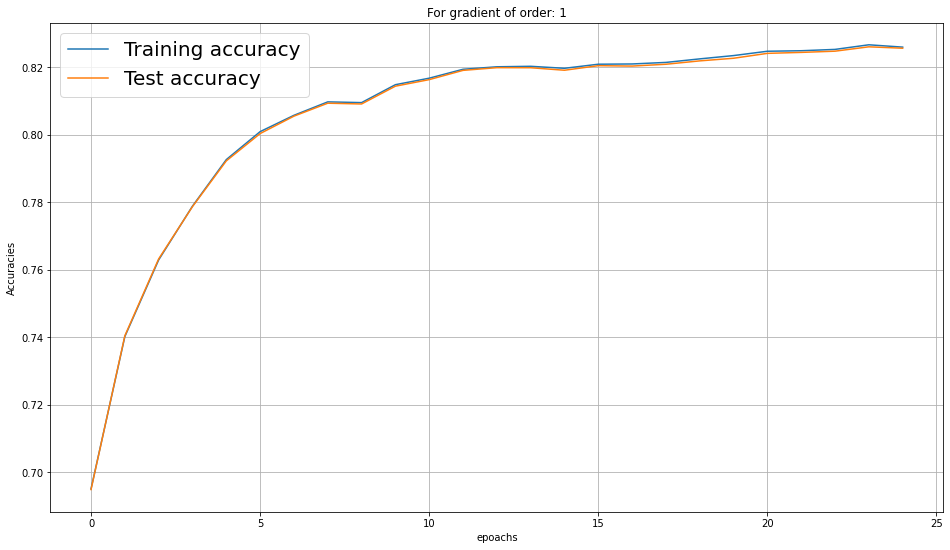

In [35]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(np.arange(len(train_acc1)), train_acc1, label='Training accuracy')
ax.plot(np.arange(len(train_acc1)), test_acc1, label='Test accuracy')

ax.set_title('For gradient of order: 1')
ax.set_xlabel('epoEchs')
ax.set_ylabel('Accuracies')

ax.legend(fontsize=20)
ax.grid()

fig.savefig(images / 'accuracy_order1.0.svg')

### Model with order : 0.9

In [36]:
############################### Train at at order = 0.9 ###################################################3
time2=time.time()

%memit layers, train_acc09, test_acc09, epochLoss09, ypred09 = FO_train_mini_batch(X_train, Y_train, X_test, Y_test, F09_initial_layers, batch_size=200, num_epoch=25, learning_rate=0.023, alpha =0.9)

time3=time.time() - time2

print('time : {} seconds'.format(time3))


Fractional order traning for order of gradient = 0.9


Epoch [0] Iteration [5000]: loss = 0.849866772653221 accuracy = 0.695
Epoch [0] Iteration [10000]: loss = 0.7297738533800122 accuracy = 0.695
Epoch [0] Iteration [15000]: loss = 0.70246839327577 accuracy = 0.735
Epoch [0] Iteration [20000]: loss = 0.7483811748163345 accuracy = 0.69
Epoch [0] Iteration [25000]: loss = 0.7296959455939365 accuracy = 0.73
Epoch [0] average_loss = 0.781901974167536 average_accuracy = 0.691098502615912
Epoch [0] train_loss = 0.712656292901504 train_accuracy = 0.7054997218135017
Epoch [0] test_accuracy = 0.705532194945593
Epoch [1] Iteration [5000]: loss = 0.6299508183281854 accuracy = 0.795
Epoch [1] Iteration [10000]: loss = 0.6256617773348981 accuracy = 0.77
Epoch [1] Iteration [15000]: loss = 0.6066404839743644 accuracy = 0.765
Epoch [1] Iteration [20000]: loss = 0.6706511764681933 accuracy = 0.705
Epoch [1] Iteration [25000]: loss = 0.6922445695430723 accuracy = 0.74
Epoch [1] average_loss = 0.62131

Epoch [14] Iteration [10000]: loss = 0.4475286642614567 accuracy = 0.8
Epoch [14] Iteration [15000]: loss = 0.43704201771495543 accuracy = 0.83
Epoch [14] Iteration [20000]: loss = 0.5102677193416244 accuracy = 0.825
Epoch [14] Iteration [25000]: loss = 0.6233589488011344 accuracy = 0.78
Epoch [14] average_loss = 0.46014655898411044 average_accuracy = 0.821799386613747
Epoch [14] train_loss = 0.4563601814733283 train_accuracy = 0.8236117194812093
Epoch [14] test_accuracy = 0.8232682259061989
Epoch [15] Iteration [5000]: loss = 0.42602434914179227 accuracy = 0.865
Epoch [15] Iteration [10000]: loss = 0.43612105830748576 accuracy = 0.825
Epoch [15] Iteration [15000]: loss = 0.43666505313671583 accuracy = 0.83
Epoch [15] Iteration [20000]: loss = 0.5121210567449359 accuracy = 0.82
Epoch [15] Iteration [25000]: loss = 0.6127486940796963 accuracy = 0.795
Epoch [15] average_loss = 0.45700560442816174 average_accuracy = 0.822865415839798
Epoch [15] train_loss = 0.4551949848545698 train_accura

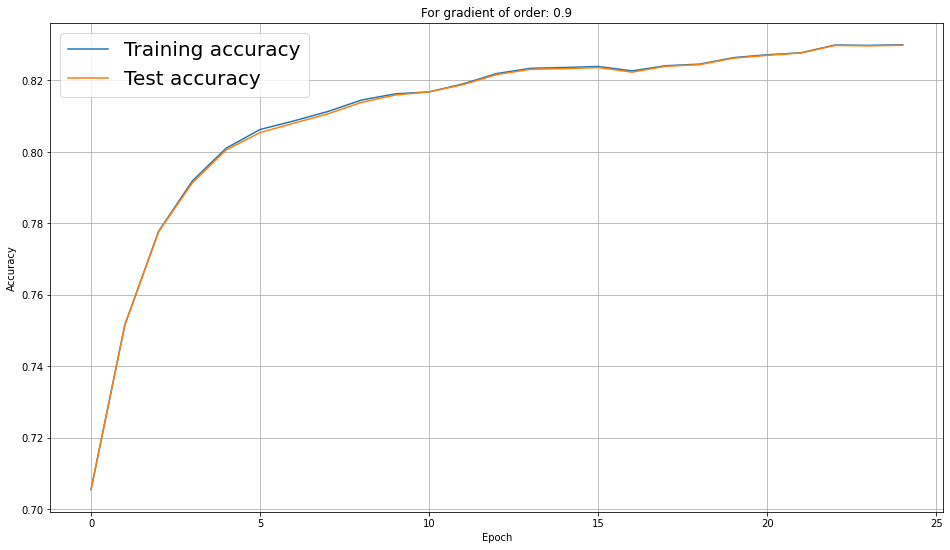

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(np.arange(len(train_acc09)), train_acc09, label='Training accuracy')
ax.plot(np.arange(len(train_acc09)), test_acc09, label='Test accuracy')

ax.set_title('For gradient of order: 0.9')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.legend(fontsize=20)
ax.grid()

fig.savefig(images / 'accuracy_order0.9.svg')

### Model with order : 1.1

In [37]:
########################################### Train at order = 1.1 ##################################################
time4 = time.time()

%memit layers, train_acc11, test_acc11, epochLoss11, ypred11  = FO_train_mini_batch(X_train, Y_train, X_test, Y_test, F11_initial_layers, batch_size=200, num_epoch=25, learning_rate=0.023, alpha= 1.1)

time5 = time.time() - time4

print('time : {} seconds'.format(time5))


Fractional order traning for order of gradient = 1.1


Epoch [0] Iteration [5000]: loss = 0.4268622533762831 accuracy = 0.87
Epoch [0] Iteration [10000]: loss = 0.415262508488174 accuracy = 0.855
Epoch [0] Iteration [15000]: loss = 0.43289881342810665 accuracy = 0.825
Epoch [0] Iteration [20000]: loss = 0.4825281630780657 accuracy = 0.83
Epoch [0] Iteration [25000]: loss = 0.6010182494155522 accuracy = 0.805
Epoch [0] average_loss = 0.437568510760074 average_accuracy = 0.8297158578387155
Epoch [0] train_loss = 0.43811416276920995 train_accuracy = 0.8302398465536265
Epoch [0] test_accuracy = 0.8300507807623393
Epoch [1] Iteration [5000]: loss = 0.4300261856829718 accuracy = 0.865
Epoch [1] Iteration [10000]: loss = 0.41565452066773434 accuracy = 0.85
Epoch [1] Iteration [15000]: loss = 0.42730551205066725 accuracy = 0.83
Epoch [1] Iteration [20000]: loss = 0.48076703603304777 accuracy = 0.82
Epoch [1] Iteration [25000]: loss = 0.597655541554177 accuracy = 0.81
Epoch [1] average_loss = 

Epoch [14] Iteration [5000]: loss = 0.4231119809883457 accuracy = 0.855
Epoch [14] Iteration [10000]: loss = 0.3973480743490348 accuracy = 0.85
Epoch [14] Iteration [15000]: loss = 0.4142696790052044 accuracy = 0.84
Epoch [14] Iteration [20000]: loss = 0.4596444538569561 accuracy = 0.84
Epoch [14] Iteration [25000]: loss = 0.5840519141693319 accuracy = 0.795
Epoch [14] average_loss = 0.4238198653991926 average_accuracy = 0.8346927656503698
Epoch [14] train_loss = 0.4225667331689925 train_accuracy = 0.8360467641967121
Epoch [14] test_accuracy = 0.8358916147878314
Epoch [15] Iteration [5000]: loss = 0.42852251036322897 accuracy = 0.85
Epoch [15] Iteration [10000]: loss = 0.40239825168956833 accuracy = 0.85
Epoch [15] Iteration [15000]: loss = 0.4139052685791218 accuracy = 0.84
Epoch [15] Iteration [20000]: loss = 0.4588301199035374 accuracy = 0.845
Epoch [15] Iteration [25000]: loss = 0.5861290065295411 accuracy = 0.79
Epoch [15] average_loss = 0.4230746528509293 average_accuracy = 0.834

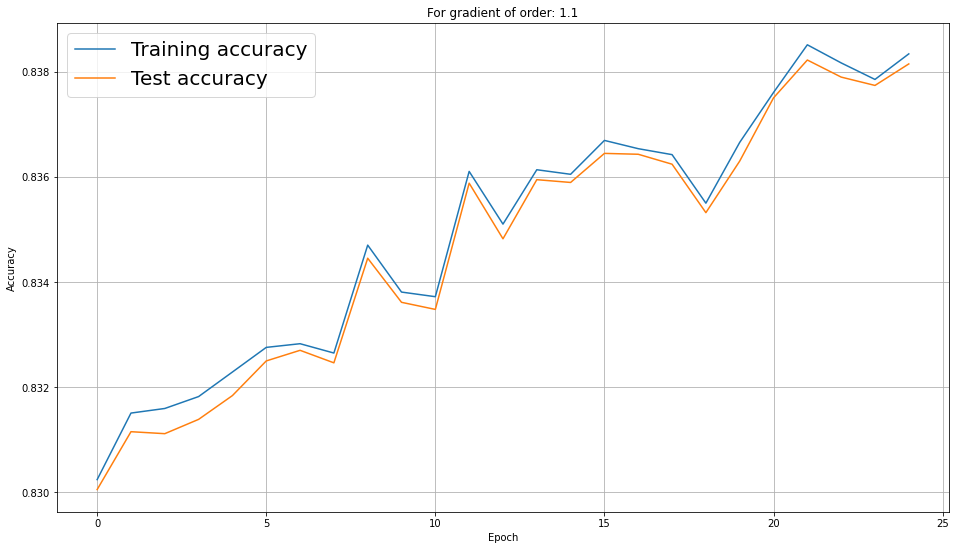

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(np.arange(len(train_acc11)), train_acc11, label='Training accuracy')
ax.plot(np.arange(len(train_acc11)), test_acc11, label='Test accuracy')

ax.set_title('For gradient of order: 1.1')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.legend(fontsize=20)
ax.grid()

fig.savefig(images / 'accuracy_order1.1.svg')

In [53]:
times = [round(time1/60, 2), round(time3/60, 2), round(time5/60, 2)]
RAM = [5346.66, 2491.38, 2237.05 ]

util = {'Grad': ['Order of 0.9', 'Order of 1', 'Order of 1.1'], 'Time': times, 'RAM': RAM}

df = pd.DataFrame.from_dict(util)

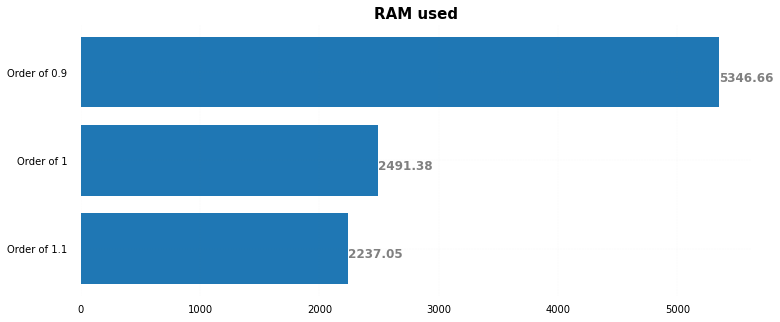

In [43]:
fig, ax = plt.subplots(figsize =(12, 5))
 
ax.barh(df['Grad'], df['RAM'])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.15,
        alpha = 0.2)
 

ax.invert_yaxis()
 

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight ='bold',
             color ='grey')


ax.set_title('RAM used', loc ='center', fontsize = 15, fontweight ='bold');

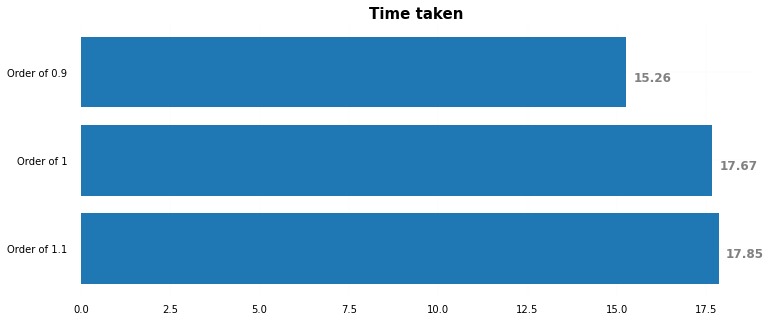

In [45]:
fig, ax = plt.subplots(figsize =(12, 5))
 
ax.barh(df['Grad'], df['Time'])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.15,
        alpha = 0.2)
 

ax.invert_yaxis()
 

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight ='bold',
             color ='grey')

ax.set_title('Time taken', loc ='center', fontsize = 15, fontweight ='bold');

## Save Results

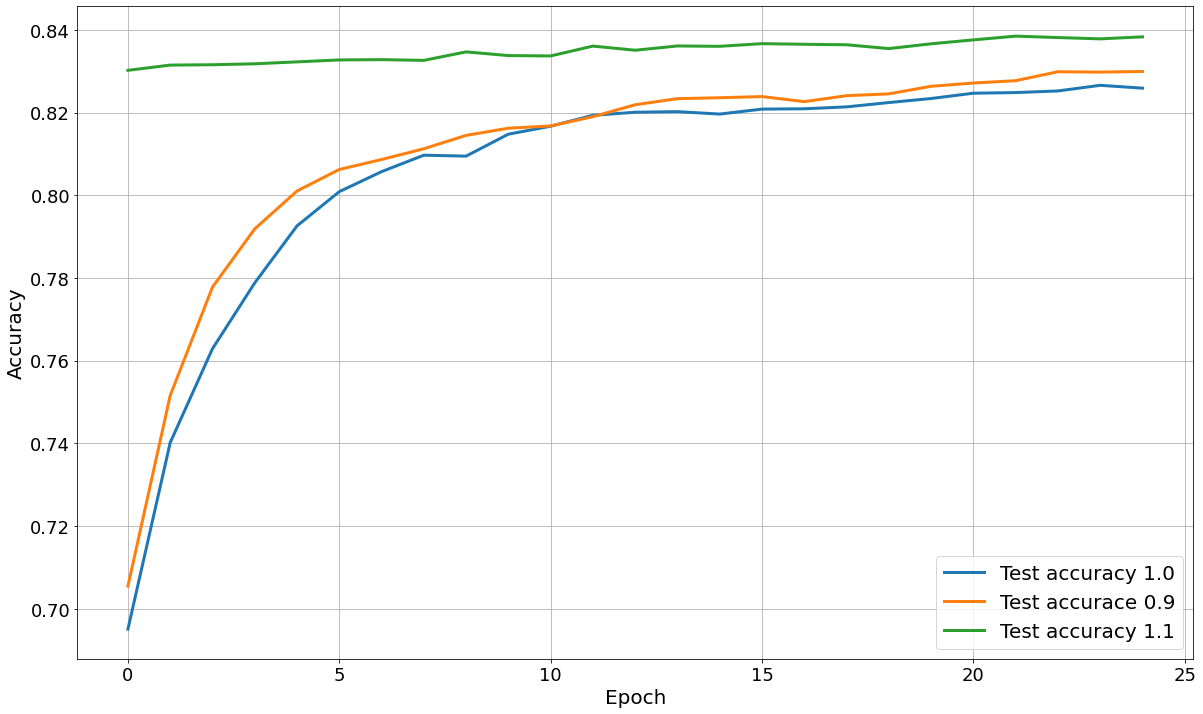

In [51]:
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(np.arange(len(train_acc1)), train_acc1, lw=3, label='Test accuracy 1.0')
ax.plot(np.arange(len(train_acc09)), train_acc09, lw=3, label='Test accurace 0.9')
ax.plot(np.arange(len(train_acc11)), train_acc11, lw=3, label='Test accuracy 1.1')

ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.grid()
ax.legend(fontsize=20);

fig.savefig(images / 'accuracy_comarison.svg')

______________________________________________________________________________________________________________

## Two more orders for checking effectiveness

### Model with order : 0.2

In [56]:
# Traning  at order = 0.2
time02 = time.time()

layers, train_acc02, test_acc02, eploss02, ypred02  = FO_train_mini_batch(X_train, Y_train, X_test, Y_test, F02_initial_layers, batch_size=200, num_epoch=1, learning_rate=0.023, alpha =0.2)

time102 = time.time()-time02

print('time : {} seconds'.format(time102))


Fractional order traning for order of gradient = 0.2


Epoch [0] Iteration [5000]: loss = 1.6390420221126218 accuracy = 0.435
Epoch [0] Iteration [10000]: loss = 1.5001868424395461 accuracy = 0.505
Epoch [0] Iteration [15000]: loss = 1.45725772794534 accuracy = 0.39
Epoch [0] Iteration [20000]: loss = 1.4085124977216374 accuracy = 0.38
Epoch [0] Iteration [25000]: loss = 1.3405662054516878 accuracy = 0.465
Epoch [0] average_loss = 1.4737519976008655 average_accuracy = 0.4418020927295688
Epoch [0] train_loss = 1.2753862299257117 train_accuracy = 0.4801989664884493
Epoch [0] test_accuracy = 0.4796324907397452
time : 37.10283899307251 seconds


### Model with order : 1.7

In [58]:
time17 = time.time()
# Train at order = 1.7
layers, train_acc17, test_acc17, eploss17, ypred17  = FO_train_mini_batch(X_train, Y_train, X_test, Y_test, F17_initial_layers, batch_size=200, num_epoch=1, learning_rate=0.023, alpha= 1.7)

time117= time.time() - time17

print('time : {} seconds'.format(time117))


Fractional order traning for order of gradient = 1.7


Epoch [0] Iteration [5000]: loss = 0.5554342536601342 accuracy = 0.815
Epoch [0] Iteration [10000]: loss = 0.6095034025482369 accuracy = 0.73
Epoch [0] Iteration [15000]: loss = 0.539554297592967 accuracy = 0.75
Epoch [0] Iteration [20000]: loss = 0.5889866763446335 accuracy = 0.765
Epoch [0] Iteration [25000]: loss = 0.6711784002302048 accuracy = 0.76
Epoch [0] average_loss = 0.5615738240269044 average_accuracy = 0.7787656503698359
Epoch [0] train_loss = 0.5501170633555841 train_accuracy = 0.7795875334924276
Epoch [0] test_accuracy = 0.7794677437162685
time : 43.33462595939636 seconds
